# Neural Networks ECE NTUA Course 2019-20 ~ Team M.B.4
## Lab Assingment #1: Classification - Study of UCI Datasets - Big (B01)

### A. The Team
* Αβραμίδης Κλεάνθης   ~ 03115117
* Κρατημένος Άγγελος   ~ 03115025
* Πανίδης Κωνσταντίνος ~ 03113602

*Σημείωση: Θεωρούμε γνωστό και δεδομένο το small notebook, συνεπώς δε θα επαναληφθούν αναλυτικά προαναφερθείσες έννοιες.*

### B. The Dataset


#### 1. Introduction

Παραθέτουμε την επίσημη περιγραφή που παρέχει το dataset:

The data are MC generated to simulate registration of high energy
   gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the
   imaging technique. Cherenkov gamma telescope observes high energy gamma rays,
   taking advantage of the radiation emitted by charged particles produced
   inside the electromagnetic showers initiated by the gammas, and developing in the
   atmosphere. This Cherenkov radiation leaks
   through the atmosphere and gets recorded in the detector, allowing reconstruction
   of the shower parameters. The available information consists of pulses left by
   the incoming Cherenkov photons on the photomultiplier tubes, arranged in a
   plane, the camera. Depending on the energy of the primary gamma, a total of
   few hundreds to some 10000 Cherenkov photons get collected in patterns,
   allowing to discriminate statistically those
   caused by primary gammas from the images of hadronic showers
   initiated by cosmic rays in the upper atmosphere. Typically, the image of a shower after some pre-processing is an elongated
   cluster. Its long axis is oriented towards the camera center if the shower axis
   is parallel to the telescope's optical axis, i.e. if the telescope axis is
   directed towards a point source. A principal component analysis is performed
   in the camera plane, which results in a correlation axis and defines an ellipse.
   The energy depositions are typically asymmetric
   along the major axis, and this asymmetry can also be used in discrimination.
   There are, in addition, further discriminating characteristics, like the
   extent of the cluster in the image plane, or the total sum of depositions.

Τα δεδομένα δημιουργήθηκαν από ένα Monte Carlo πρόγραμμα, Corsika, και περιγράφεται από το 
      *D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
      Forschungszentrum Karlsruhe FZKA 6019 (1998).*

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

Using TensorFlow backend.


#### 2. Samples & Features

In [2]:
data = pd.read_csv("magic04.data",header=None).to_numpy()
print("The Dataset contains",data.shape[0],"samples,",data.shape[1]-1,"features and a label.")

The Dataset contains 19020 samples, 10 features and a label.


Προκύπτει ότι το Dataset αποτελείται από 19020 δείγματα, καθένα εκ των οποίων έχει 10 χαρακτηριστικά συν την binary ετικέτα του. Στη συνέχεια θα εξετάσουμε το είδος των χαρακτηριστικών μέσω του δείγματος μιας και το dataset δεν έχει απουσιάζουσες τιμές.

In [3]:
print("Data types of features:",set([type(feature) for feature in data[0]]))
print("Inspection of features:",data[0])

Data types of features: {<class 'str'>, <class 'float'>}
Inspection of features: [28.7967 16.0021 2.6449 0.3918 0.1982 27.7004 22.011 -8.2027 40.092
 81.8828 'g']


Παρατηρούμε πως όλα τα χαρακτηριστικά λαμβάνουν αριθμητικές float τιμές και η μόνη μη διατεταγμένη μορφή είναι η τελευταία στήλη που υποδηλώνει το label και είναι τύπου str.

#### 4. Labels

Σύμφωνα με το documentation, οι ετικέτες των δειγμάτων λαμβάνουν τις τιμές g (gamma) ή h (hadron) και βρίσκονται στην τελευταία κολόνα του ```data```:

In [4]:
labels = data[:,-1]
feats  = data[:,:-1]
print("Labels of the Dataset:",set(labels))

Labels of the Dataset: {'h', 'g'}


#### 5. Pre-Processing

Δεν απαιτήθηκε κάποια προσαρμογή των input files.

#### 6. Missing Values

Δεν υπάρχουν απουσιάζουσες τιμές σύμφωνα με το documentation του dataset.

#### 7. Balance

Λόγω της binary φύσης των labels, μπορούμε να εκτιμήσουμε απευθείας πόσα στοιχεία ανήκουν σε κάθε κλάση μέσω της συνάρτησης sum(), άρα και να αποφανθούμε περί της ισορροπίας του Dataset, διαιρώντας με τον συνολικό αριθμό των δειγμάτων:

In [5]:
np_labels = np.array(labels)
print(feats.shape)
print(len(np_labels[np_labels=='g']),"samples are gamma and",len(np_labels)-len(np_labels[np_labels=='g']),"are hadron")
print("The balance of the Dataset is",round(len(np_labels[np_labels=='g'])/len(labels),2),"in favor of the gamma samples.")

(19020, 10)
12332 samples are gamma and 6688 are hadron
The balance of the Dataset is 0.65 in favor of the gamma samples.


Είναι εμφανές πως τα δεδομένα κλίνουν κατά ένα βαθμό στην κλάση gamma, συνεπώς τα δεδομένα μας δεν είναι καλώς ισορροπημένα. Παρότι το ποσοστό παραμένει οριακά μικρότερο από 2/3 και θα μπορούσαμε να μην κάνουμε κάτι επιπλέον, επιλέγουμε να εφαρμόσουμε oversampling, θεωρώντας ότι όσο πιο ισορροπημένο είναι το dataset, τόσο καλύτερα θα είναι τα αποτελέσματα. Για να γίνει αυτό θα προηγηθεί το split.

#### 8. Train & Test Set

Σαν τελευταίο βήμα επεξεργασίας, θα χωρίσουμε τα δεδομένα σε train και test μέσω της αντίστοιχης συνάρτησης *train_test_split()* της Scikit-learn. Αντίστοιχα χωρίζουμε και τα labels. Επιλέγουμε σχήμα 20% για το test set:

In [6]:
x_train,x_test,y_train,y_test = train_test_split(feats,labels,test_size=0.3,random_state=0) 

Ως τελευταίο βήμα, θα εφαρμόσουμε oversampling ούτως ώστε να εξισορροπήσουμε το dataset, όπως προείπαμε. Η έννοια του oversampling ειναι πρακτικά η επανάληψη samples από την υπολείπουσα κλάση, ώστε ο λόγος τους να τείνει προς το ιδανικό 50%. Θα εφαρμόσουμε για αυτό το σκοπό την συνάρτηση της Scikit-learn:

In [7]:
ros = RandomOverSampler(random_state = 0)
x_train, y_train = ros.fit_sample(x_train,y_train)
balance = len(y_train[y_train=='g'])/len(y_train)

print("The balance of the train set is",balance)

The balance of the train set is 0.5


Παρατηρούμε την απευθείας βελτίωση στο λόγο των 2 κλάσεων. Σημειώνουμε πως επιλέγουμε να ισορροπήσουμε μόνο τα δεδομένα εκπαίδευσης, τα οποία είναι και τα μόνα που οφείλουν να είναι ισορροπημένα. Γενικώς αποφεύγουμε οποιαδήποτε περαιτέρω επεξεργασία στα test δεδομένα.

### C. Baseline Classification

#### 1. Classification & Metrics

Ορίζουμε μία συνάρτηση που εκπαιδεύει τους dummy classifiers με default τιμές και επιστρέφει σε dictionary τα predictions κάθε ταξινομητή, την ακρίβεια του καθώς και τους χρόνους fit και train 


In [8]:
def DummyClassification(x_train,y_train,x_test,y_test):
    
    scores, predictions, fit_times, pred_times = {}, {}, {}, {}

    ### Initialization ###
    
    dc_uniform  = DummyClassifier(strategy="uniform")
    dc_const_0  = DummyClassifier(strategy="constant",constant='g')
    dc_const_1  = DummyClassifier(strategy="constant",constant='h')
    dc_stratif  = DummyClassifier(strategy="stratified")
    dc_frequent = DummyClassifier(strategy="most_frequent")

    ### Fit ###
    
    start_time = time.time()
    dc_uniform.fit(x_train, y_train)
    fit_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_0.fit(x_train, y_train)
    fit_times['const_0'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_1.fit(x_train, y_train)
    fit_times['const_1'] = time.time()-start_time
    
    start_time = time.time()
    dc_stratif.fit(x_train, y_train)
    fit_times['stratif'] = time.time()-start_time
    
    start_time = time.time()
    dc_frequent.fit(x_train,y_train)
    fit_times['frequent'] = time.time()-start_time
    
    ### Predict ###
    
    start_time = time.time()
    predictions['uniform']  = dc_uniform.predict(x_test)
    pred_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_0']  = dc_const_0.predict(x_test)
    pred_times['const_0'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_1']  = dc_const_1.predict(x_test)
    pred_times['const_1'] = time.time()-start_time
    
    start_time = time.time()
    predictions['stratif']  = dc_stratif.predict(x_test)
    pred_times['stratif'] = time.time()-start_time
    
    start_time = time.time()
    predictions['frequent'] = dc_frequent.predict(x_test)
    pred_times['frequent'] = time.time()-start_time

    ### Score ###
    
    scores['uniform']  = dc_uniform.score(x_test, y_test)
    scores['const_0']  = dc_const_0.score(x_test, y_test)
    scores['const_1']  = dc_const_1.score(x_test, y_test)
    scores['stratif']  = dc_stratif.score(x_test, y_test)
    scores['frequent'] = dc_frequent.score(x_test,y_test)
    
    return predictions, scores, fit_times, pred_times

In [9]:
predictions, big_accuracies, _, _ = DummyClassification(x_train,y_train,x_test,y_test)

print("Classification Accuracy of Dummy Classifiers for the test set:\n")
for strategy in big_accuracies: print("With",strategy,"strategy:",np.round(100*big_accuracies[strategy],3),"%")

print("\nConfusion Matrices of Dummy Classifiers for the test set:\n")
for strategy in predictions: print("With",strategy,"strategy:\n",confusion_matrix(y_test,predictions[strategy]))

for strategy in predictions:
    print("\nf1-micro average of",strategy,"strategy:",f1_score(y_test,predictions[strategy], average='micro'))
    print("f1-macro average of",strategy,"strategy:",f1_score(y_test,predictions[strategy], average='macro'))
    

Classification Accuracy of Dummy Classifiers for the test set:

With uniform strategy: 48.931 %
With const_0 strategy: 64.651 %
With const_1 strategy: 35.349 %
With stratif strategy: 49.334 %
With frequent strategy: 64.651 %

Confusion Matrices of Dummy Classifiers for the test set:

With uniform strategy:
 [[1867 1822]
 [ 961 1056]]
With const_0 strategy:
 [[3689    0]
 [2017    0]]
With const_1 strategy:
 [[   0 3689]
 [   0 2017]]
With stratif strategy:
 [[1850 1839]
 [1005 1012]]
With frequent strategy:
 [[3689    0]
 [2017    0]]

f1-micro average of uniform strategy: 0.5122677882930249
f1-macro average of uniform strategy: 0.5022118469758436

f1-micro average of const_0 strategy: 0.6465124430424115
f1-macro average of const_0 strategy: 0.3926556679084619

f1-micro average of const_1 strategy: 0.3534875569575885
f1-macro average of const_1 strategy: 0.2611679399197203

f1-micro average of stratif strategy: 0.501577287066246
f1-macro average of stratif strategy: 0.4905899612860194


In [10]:
gnb = GaussianNB()
gnb.fit(x_train,y_train)
predictions['gnb'] = gnb.predict(x_test)
big_accuracies['gnb'] = gnb.score(x_test,y_test)

knn = KNeighborsClassifier(n_neighbors=1) 
knn.fit(x_train,y_train)
predictions['knn'] = knn.predict(x_test)
big_accuracies['knn'] = knn.score(x_test,y_test)

mlp = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(10,2),random_state=1,max_iter=1000) 
mlp.fit(x_train,y_train)
predictions['mlp'] = mlp.predict(x_test)
big_accuracies['mlp'] = mlp.score(x_test,y_test)

In [11]:
print("Classification Accuracy of GNB for the test set:",np.round(100*big_accuracies['gnb'],3),"%")
print("\nConfusion Matrix of GNB for the test set:\n",confusion_matrix(y_test,predictions['gnb']))
print("\nf1-micro average of GNB Classifier:",f1_score(y_test,predictions['gnb'], average='micro'))
print("f1-macro average of GNB Classifier:",f1_score(y_test,predictions['gnb'], average='macro'))
print();print()

print("Classification Accuracy of 1-NN for the test set:",np.round(100*big_accuracies['knn'],3),"%")
print("\nConfusion Matrix of 1-NN for the test set:\n",confusion_matrix(y_test,predictions['knn']))
print("\nf1-micro average of 1-NN Classifier:",f1_score(y_test,predictions['knn'], average='micro'))
print("f1-macro average of 1-NN Classifier:",f1_score(y_test,predictions['knn'], average='macro'))
print();print()

print("Classification Accuracy of MLP for the test set:",np.round(100*big_accuracies['mlp'],3),"%")
print("\nConfusion Matrix of MLP for the test set:\n",confusion_matrix(y_test,predictions['mlp']))
print("\nf1-micro average of MLP Classifier:",f1_score(y_test,predictions['mlp'], average='micro'))
print("f1-macro average of MLP Classifier:",f1_score(y_test,predictions['mlp'], average='macro'))

Classification Accuracy of GNB for the test set: 72.205 %

Confusion Matrix of GNB for the test set:
 [[3317  372]
 [1214  803]]

f1-micro average of GNB Classifier: 0.7220469681037505
f1-macro average of GNB Classifier: 0.6550943965753802


Classification Accuracy of 1-NN for the test set: 77.83 %

Confusion Matrix of 1-NN for the test set:
 [[3189  500]
 [ 765 1252]]

f1-micro average of 1-NN Classifier: 0.778303540133193
f1-macro average of 1-NN Classifier: 0.7494281405630201


Classification Accuracy of MLP for the test set: 66.158 %

Confusion Matrix of MLP for the test set:
 [[3682    7]
 [1924   93]]

f1-micro average of MLP Classifier: 0.6615842972309849
f1-macro average of MLP Classifier: 0.4400570397227495


#### 2. Bar Plots

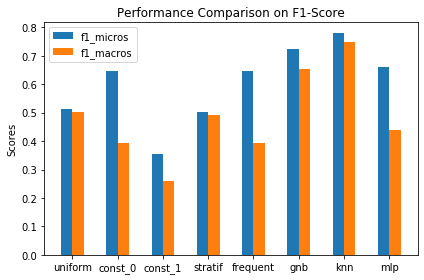

In [12]:
f1_macros, f1_micros, labels = [],[],[]
for clf in predictions:  
    f1_micros.append(f1_score(y_test,predictions[clf],average='micro'))
    f1_macros.append(f1_score(y_test,predictions[clf],average='macro'))
    labels.append(clf)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, f1_macros, width, label='f1_macros')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

#### 3. Discussion

In [13]:
print("The balance of the test set is",round(100*len(y_test[y_test=='g'])/len(y_test),3),"in favor of class 'g'.")

The balance of the test set is 64.651 in favor of class 'g'.


* Μεταξύ των dummy ταξινομητών, η καλύτερη στρατηγική είναι να διαλέγουμε πάντοτε την πιο συχνή κλάση (frequent) ή ισοδύναμα σταθερά την κλάση που είναι η πιο συχνή (constant-0), μιας και το test set δεν είναι ισορροπημένο, όπως φαίνεται παραπάνω.
* Εαν δοκιμάσουμε πολλά runs, θα παρατηρήσουμε ότι η επιλογή stratified, δηλαδή να επιλέγουμε τυχαία κλάση διατηρώντας την κατανομή των κλάσεων στο training set, ενώ στη γενική περίπτωση δίνει καλύτερα αποτελέσματα από τη random επιλογή, στη προκειμένη, λόγω της ισορροπίας του train dataset, οι δύο μέθοδοι είναι ισοδύναμες. 
* Ο k-NN ταξινομητής δίνει καλύτερο αποτέλεσμα από τους dummy classifiers, αφού βασίζεται σε έναν αλγόριθμο λογικής ανάλυσης των δεδομένων. Επιπλέον λόγω του εκτενούς μεγέθους του test dataset, το αποτέλεσμα του ταξινομητή είναι ικανοποιητικό.
* Ο Naive Bayes εμφανίζει επίσης βελτιωμένα αποτελέσματα συγκριτικά με τους dummy ταξινομητές, αλλά όχι καλύτερα από τον kNN. Αυτό οφείλεται στις "αφελείς" παραδοχές του συγκεκριμένου ταξινομήτη, όπως το ότι υποθέτει κανονική κατανομή των features και ανεξαρτησία μεταξύ τους.
* Τέλος, ο MLP εμφανίζει την χαμηλότερη επίδοση από τους non-Dummy ταξινομητές. Ο συγκεκριμένος ταξινομητής λαμβάνει πληθώρα παραμέτρων, η βελτιστοποίηση των οποίων θα οδηγήσει σε πιο ικανοποιητικό αποτέλεσμα. Επομένως, λόγω της επιλογής απλοϊκού συνδυασμού παραμέτρων, το ποσοστό είναι μέτριο αλλά παραμένει υψηλότερο από τους Dummy ταξινομητές.

### D. Optimization of Classifiers

Θα ακολουθήσουμε bottom-up λογική όπως στο small notebook. Για την εύρεση των βέλτιστων υπερπαραμέτρων θα διαχωρίσουμε το dataset σε 70% train και 30% test και θα χρησιμοποιήσουμε 5-fold cross validation για να εκτιμήσουμε τις παραμέτρους μόνο από το train set. Συγκεκριμένα, αφού γίνει η απαραίτητη προεπεξεργασία ολόκληρου του set, αυτό θα χωριστεί σε 5 subsets, καθένα από τα οποία θα δοκιμαστεί σαν validation set. Στη συνέχεια, οι παράμετροι θα δώσουν το καλύτερο cross score θα εφαρμοστούν προκειμένου να κάνουμε το τελικό prediction για το αρχικό μας test set.

#### 1-2. Pre-Processing - Optimization and Execution Time

Για αρχή θα τρέξουμε πάλι τους dummy classifiers καθώς και τον Gaussian Naive Bayes, οι οποίοι δεν επηρεάζονται από το processing που θα ακολουθήσουμε. Αυτή τη φορά θα κάνουμε και track των χρόνων για fit και predict:

In [14]:
npredictions, nbig_accuracies, fit_times, pred_times = DummyClassification(x_train,y_train,x_test,y_test)

npredictions['gnb'] = predictions['gnb']
nbig_accuracies['gnb'] = big_accuracies['gnb']

print("Classification Accuracy of Dummy Classifiers for the test set:\n")
for strategy in nbig_accuracies: print("With",strategy,"strategy:",np.round(100*nbig_accuracies[strategy],3),"%")

print("\nConfusion Matrices of Dummy Classifiers for the test set:\n")
for strategy in npredictions: print("With",strategy,"strategy:\n",confusion_matrix(y_test,npredictions[strategy]))

for strategy in npredictions:
    print("\nf1-micro average of",strategy,"strategy:",f1_score(y_test,npredictions[strategy], average='micro'))
    print("f1-macro average of",strategy,"strategy:",f1_score(y_test,npredictions[strategy], average='macro'))
    
print("\nFit and Predict duration of Dummy Classifiers in secs:\n")
for strategy in fit_times:
    print("Fitting time for",strategy,"strategy:",fit_times[strategy])
    print("Predict time for",strategy,"strategy:",pred_times[strategy],"\n")

Classification Accuracy of Dummy Classifiers for the test set:

With uniform strategy: 50.123 %
With const_0 strategy: 64.651 %
With const_1 strategy: 35.349 %
With stratif strategy: 50.368 %
With frequent strategy: 64.651 %
With gnb strategy: 72.205 %

Confusion Matrices of Dummy Classifiers for the test set:

With uniform strategy:
 [[1853 1836]
 [1009 1008]]
With const_0 strategy:
 [[3689    0]
 [2017    0]]
With const_1 strategy:
 [[   0 3689]
 [   0 2017]]
With stratif strategy:
 [[1820 1869]
 [1016 1001]]
With frequent strategy:
 [[3689    0]
 [2017    0]]
With gnb strategy:
 [[3317  372]
 [1214  803]]

f1-micro average of uniform strategy: 0.5014020329477743
f1-macro average of uniform strategy: 0.4902223187610536

f1-micro average of const_0 strategy: 0.6465124430424115
f1-macro average of const_0 strategy: 0.3926556679084619

f1-micro average of const_1 strategy: 0.3534875569575885
f1-macro average of const_1 strategy: 0.2611679399197203

f1-micro average of stratif strategy: 

Βλέπουμε, όπως και στο small notebook πως το fitting διαρκεί πολύ περισσότερο από το prediction. Ορίζουμε τώρα μία συνάρτηση που θα χρησιμοποιήσουμε, όπως και στο small για την εκτέλεση του PCA:

In [15]:
def applyPCA(data,num=len(data[0])):
    pca = PCA(n_components=num)
    return pca.fit_transform(data)

Αρχικοποιούμε τους εκτιμητές χωρίς παραμέτρους:

In [16]:
selector = VarianceThreshold() # by default removes zero variance elements
m_scaler = MinMaxScaler()
pca = PCA()
clf = KNeighborsClassifier(n_jobs=-1) # uses all available cores
mlp = MLPClassifier()

Η διαδικασία εύρεσης των βέλτιστων υπερπαραμέτρων είναι εκ γενετής μια χρονοβόρα και επαναληπτική διαδικασία πειραματισμών. Για αυτό το λόγο θα εκμεταλλευτούμε το μεγάλο μέγεθος του dataset και θα χρησιμοποιήσουμε μόνο ένα υποσύνολο των διαθέσιμων δειγμάτων, μέσω sampling:

In [17]:
x_train_copy = x_train
y_train_copy = y_train
x_test_copy  = x_test
y_test_copy  = y_test

x_train_sample, y_train_sample = shuffle(x_train, y_train, random_state=3)
x_train_sample = x_train_sample[0:2000,:]
y_train_sample = y_train_sample[0:2000]

Μπορούμε τώρα να προσχωρήσουμε στην εύρεση των βέλτιστων παραμέτρων των μοντέλων μας. Θα εξετάσουμε χωριστά τις παραμέτρους των ταξινομητών MLP και k-NN καθώς ο Gaussian Naive Bayes δε διαθέτει παραμέτρους προς βελτιστοποίηση. Επίσης, επιλέγουμε να μην κάνουμε feature selection καθώς ο αριθμός των features είναι ήδη αρκετά μικρός σε σύγκριση με την ποσότητα των δεδομένων. Ξεκινάμε με τον k-NN classifier:

In [18]:
n_components = np.arange(1,11)
k = np.arange(1,50,5)
knn_weights = ['uniform','distance']
knn_metrics = ['euclidean','manhattan','chebyshev']

Μπορούμε πλέον να στήσουμε το Pipeline για το classification των δεδομένων μας. Θα επιλέξουμε MinMax scaler:

In [19]:
pipe = Pipeline(steps=[('scaler', m_scaler),('selector', selector),('pca', pca),('kNN', clf)], memory = 'tmp')
estimator_knn = GridSearchCV(pipe, dict(pca__n_components = n_components,
                                        kNN__n_neighbors = k,
                                        kNN__weights = knn_weights,
                                        kNN__metric = knn_metrics), cv=5, scoring='f1_macro', n_jobs=-1,verbose=1)

start_time = time.time()
estimator_knn.fit(x_train_sample,y_train_sample)
preds = estimator_knn.predict(x_test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time()-start_time))
print("Best parameters",estimator_knn.best_params_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.3min finished


Συνολικός χρόνος fit και predict: 499.81396865844727 seconds
Best parameters {'kNN__metric': 'manhattan', 'kNN__n_neighbors': 6, 'kNN__weights': 'distance', 'pca__n_components': 10}


Έχοντας εξάγει παραμέτρους για ένα μικρό δείγμα του train set, επαναλαμβάνουμε την διαδικασία για όλο το dataset με πολύ μικρότερο εύρος παραμέτρων:

In [21]:
n_components = np.arange(9,11)
k = np.arange(3,9)
knn_weights = ['distance']
knn_metrics = ['manhattan']

In [23]:
pipe = Pipeline(steps=[('scaler', m_scaler),('selector', selector),('pca', pca),('kNN', clf)], memory = 'tmp')
estimator_knn = GridSearchCV(pipe, dict(pca__n_components = n_components,
                                        kNN__n_neighbors = k,
                                        kNN__weights = knn_weights,
                                        kNN__metric = knn_metrics), cv=5, scoring='f1_macro', n_jobs=-1,verbose=1)

start_time = time.time()
estimator_knn.fit(x_train,y_train)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time()-start_time))
print("Best parameters",estimator_knn.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Συνολικός χρόνος fit και predict: 82.72279739379883 seconds
Best parameters {'kNN__metric': 'manhattan', 'kNN__n_neighbors': 8, 'kNN__weights': 'distance', 'pca__n_components': 10}


Εφαρμόζουμε τώρα τις βέλτιστες παραμέτρους για να εκπαιδεύσουμε το train set στον k-NN:

In [24]:
x_train_copy = m_scaler.fit_transform(x_train)
x_test_copy = m_scaler.fit_transform(x_test)

x_train_copy = applyPCA(x_train_copy, estimator_knn.best_params_['pca__n_components'])
x_test_copy = applyPCA(x_test_copy, estimator_knn.best_params_['pca__n_components'])

knn = KNeighborsClassifier(n_neighbors = estimator_knn.best_params_['kNN__n_neighbors'],
                           metric = estimator_knn.best_params_['kNN__metric'],
                           weights = estimator_knn.best_params_['kNN__weights'])                             

start_time = time.time()
knn.fit(x_train_copy,y_train_copy)
fit_times['knn'] = time.time()-start_time

start_time = time.time()
npredictions['knn'] = knn.predict(x_test_copy)
pred_times['knn'] = time.time()-start_time

nbig_accuracies['knn'] = knn.score(x_test_copy,y_test)

print("Classification Accuracy of k-NN:",np.round(100*nbig_accuracies['knn'],3),"%")
print("\nConfusion Matrix of k-NN:\n",confusion_matrix(y_test,npredictions['knn']))
print("\nClassification Report of k-NN:\n",classification_report(y_test,npredictions['knn']))

Classification Accuracy of k-NN: 79.811 %

Confusion Matrix of k-NN:
 [[3021  668]
 [ 484 1533]]

Classification Report of k-NN:
               precision    recall  f1-score   support

           g       0.86      0.82      0.84      3689
           h       0.70      0.76      0.73      2017

    accuracy                           0.80      5706
   macro avg       0.78      0.79      0.78      5706
weighted avg       0.80      0.80      0.80      5706



Για τον MLP ακολουθούμε την ίδια προσέγγιση. Επειδή εδώ έχουμε περισσότερες παραμέτρους και το grid search θα είναι χρονοβόρο, θα δοκιμάσουμε να προσεγγίσουμε τις βέλτιστες τιμές σε περισσότερα σε 2 στάδια. Εδω παραθέτουμε το δεύτερο, αφού έχουμε προσδιορίσει τις διακριτές τιμές. Τα υπόλοιπα τρεξίματα παραλείπονται καθώς και μόνο η επανεκτέλεση προκειμένου να ολοκληρωθεί το notebook μπορεί να τρέχει υπερβολικά πολλές ώρες.

In [29]:
mlp_hidden_layers = [(i,2) for i in range(8,256,64)]
mlp_activation = ['logistic']    # ['logistic','identity','tanh','relu']
mlp_solver = ['lbfgs']           # ['lbfgs', 'sgd', 'adam']
mlp_max_iter = np.arange(50,400,100)
mlp_learning_rate = ['constant'] # ['constant', 'invscaling', 'adaptive']
alpha = np.geomspace(1e-8,1e-3,5)
n_components = np.arange(8,11)

Ορίζουμε το Pipeline:

In [30]:
pipe = Pipeline(steps=[('scaler', m_scaler),('selector', selector),('pca', pca),('mlp', mlp)], memory = 'tmp')
estimator_mlp = GridSearchCV(pipe, dict(pca__n_components = n_components,
                                            mlp__hidden_layer_sizes=mlp_hidden_layers,
                                            mlp__activation=mlp_activation,
                                            mlp__solver=mlp_solver,
                                            mlp__alpha=alpha,
                                            mlp__learning_rate=mlp_learning_rate,
                                            mlp__max_iter=mlp_max_iter), cv=5, scoring='f1_macro', n_jobs=-1,
                                                                                                   verbose=1)

start_time = time.time()
estimator_mlp.fit(x_train_sample,y_train_sample)
preds = estimator_mlp.predict(x_test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time()-start_time))
print("Best parameters",estimator_mlp.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 18.5min finished


Συνολικός χρόνος fit και predict: 1120.19082570076 seconds
Best parameters {'mlp__activation': 'logistic', 'mlp__alpha': 3.162277660168379e-06, 'mlp__hidden_layer_sizes': (136, 2), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 350, 'mlp__solver': 'lbfgs', 'pca__n_components': 10}


/home/klean/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Έχοντας εντοπίσει τις βέλτιστες παραμέτρους για ένα μικρό δείγμα του train dataset, μπορούμε να επαναλάβουμε την διαδικασία για όλο το dataset με πολύ μικρότερο εύρος παραμέτρων, ωστόσο αυτό είναι αρκετά χρονοβόρο (20000 δείγματα) και με βάση τα παραπάνω αποτελέσματα και το είδος των παραμέτρων, δεν περιμένουμε σημαντική μεταβολή των αποτελεσμάτων. Συνεπώς, εφαρμόζουμε τις βέλτιστες παραμέτρους για να εκπαιδεύσουμε το MLP:

In [31]:
x_train_copy = m_scaler.fit_transform(x_train)
x_test_copy = m_scaler.fit_transform(x_test)

x_train_copy = applyPCA(x_train_copy, estimator_mlp.best_params_['pca__n_components'])
x_test_copy = applyPCA(x_test_copy, estimator_mlp.best_params_['pca__n_components'])

mlp = MLPClassifier(solver=estimator_mlp.best_params_['mlp__solver'],
                    alpha=estimator_mlp.best_params_['mlp__alpha'],
                    hidden_layer_sizes=estimator_mlp.best_params_['mlp__hidden_layer_sizes'],
                    random_state=1,
                    activation=estimator_mlp.best_params_['mlp__activation'],
                    learning_rate=estimator_mlp.best_params_['mlp__learning_rate'],
                    max_iter=estimator_mlp.best_params_['mlp__max_iter']) 

start_time = time.time()
mlp.fit(x_train_copy,y_train_copy)
fit_times['mlp'] = time.time()-start_time

start_time = time.time()
npredictions['mlp'] = mlp.predict(x_test_copy)
pred_times['mlp'] = time.time()-start_time

nbig_accuracies['mlp'] = mlp.score(x_test_copy,y_test)

print("Classification Accuracy of MLP:",np.round(100*nbig_accuracies['mlp'],3),"%")
print("\nConfusion Matrix of MLP:\n",confusion_matrix(y_test,npredictions['mlp']))
print("\nClassification Report of MLP:\n",classification_report(y_test,npredictions['mlp']))

/home/klean/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Classification Accuracy of MLP: 77.936 %

Confusion Matrix of MLP:
 [[2799  890]
 [ 369 1648]]

Classification Report of MLP:
               precision    recall  f1-score   support

           g       0.88      0.76      0.82      3689
           h       0.65      0.82      0.72      2017

    accuracy                           0.78      5706
   macro avg       0.77      0.79      0.77      5706
weighted avg       0.80      0.78      0.78      5706



#### 3. Bar Plots

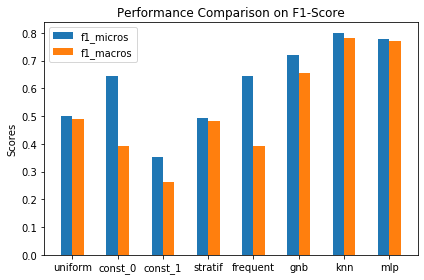

In [32]:
f1_macros, f1_micros, labels = [],[],[]
for clf in npredictions:  
    f1_micros.append(f1_score(y_test,npredictions[clf],average='micro'))
    f1_macros.append(f1_score(y_test,npredictions[clf],average='macro'))
    labels.append(clf)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, f1_macros, width, label='f1_macros')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

#### 4. Optimization Table

In [33]:
for clf in nbig_accuracies: print("Improvement for",clf,":",nbig_accuracies[clf]-big_accuracies[clf])

Improvement for uniform : 0.01191728005608128
Improvement for const_0 : 0.0
Improvement for const_1 : 0.0
Improvement for stratif : 0.010339992989835234
Improvement for frequent : 0.0
Improvement for gnb : 0.0
Improvement for knn : 0.019803715387311627
Improvement for mlp : 0.11777076761303895


#### 5. Discussion

Όπως περιγράψαμε παραπάνω, ακολουθήσαμε μια bottom-up λογική για να επιλέξουμε τις βέλτιστες υπερπαραμέτρους pre-processing και training του dataset, ούτως ώστε να αυξήσουμε το accuracy της ταξινόμησης. Τα αποτελέσματα προφανώς είναι ταυτόσημα για τους dummy classifiers και τον Naive Bayes, οι οποίοι ταξινομητές δεν έχουν παραμέτρους προς βελτιστοποίηση. Aπό την άλλη, παρατηρούμε, όπως φαίνεται και στον optimization table, πως το tuning καταφέρνει να βελτιώσει αισθητά την επίδοση τόσο του k-NN όσο κυρίως του MLP Classifier που είχε και τις περισσότερες διαθέσιμες υπερπαραμέτρους (+11%). Όσον αφορά το classification accuracy, το καλύτερο ποσοστό το πετυχαίνει ο k-NN ο οποίος συνιστά πράγματι ένα ικανοποιητικό μοντέλο για το συγκεκριμένο task, με ποσοστό επιτυχίας κοντά στο 80%.